In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [3]:
dataset = []
for folder in ["/content/drive/MyDrive/HeartbeatSounds/set_a.zip/**","/content/drive/MyDrive/HeartbeatSounds/set_b.zip/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
                #initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=45)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 220 to 203
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  244 non-null    object 
 1   label     244 non-null    object 
 2   offset    244 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.6+ KB


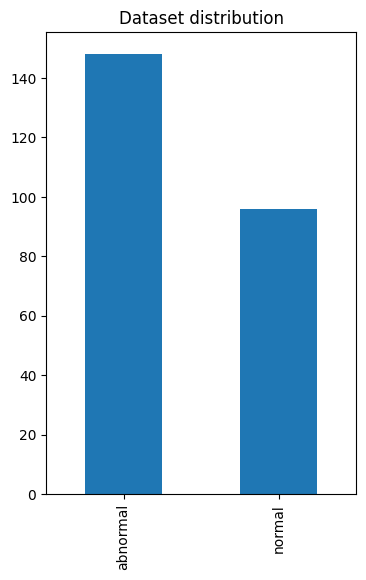

In [4]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [5]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 195
Test: 49


## Visualising the data and features

/content/drive/MyDrive/HeartbeatSounds/set_a.zip/normal__201105021804.wav
/content/drive/MyDrive/HeartbeatSounds/set_a.zip/extrahls__201103182227.wav


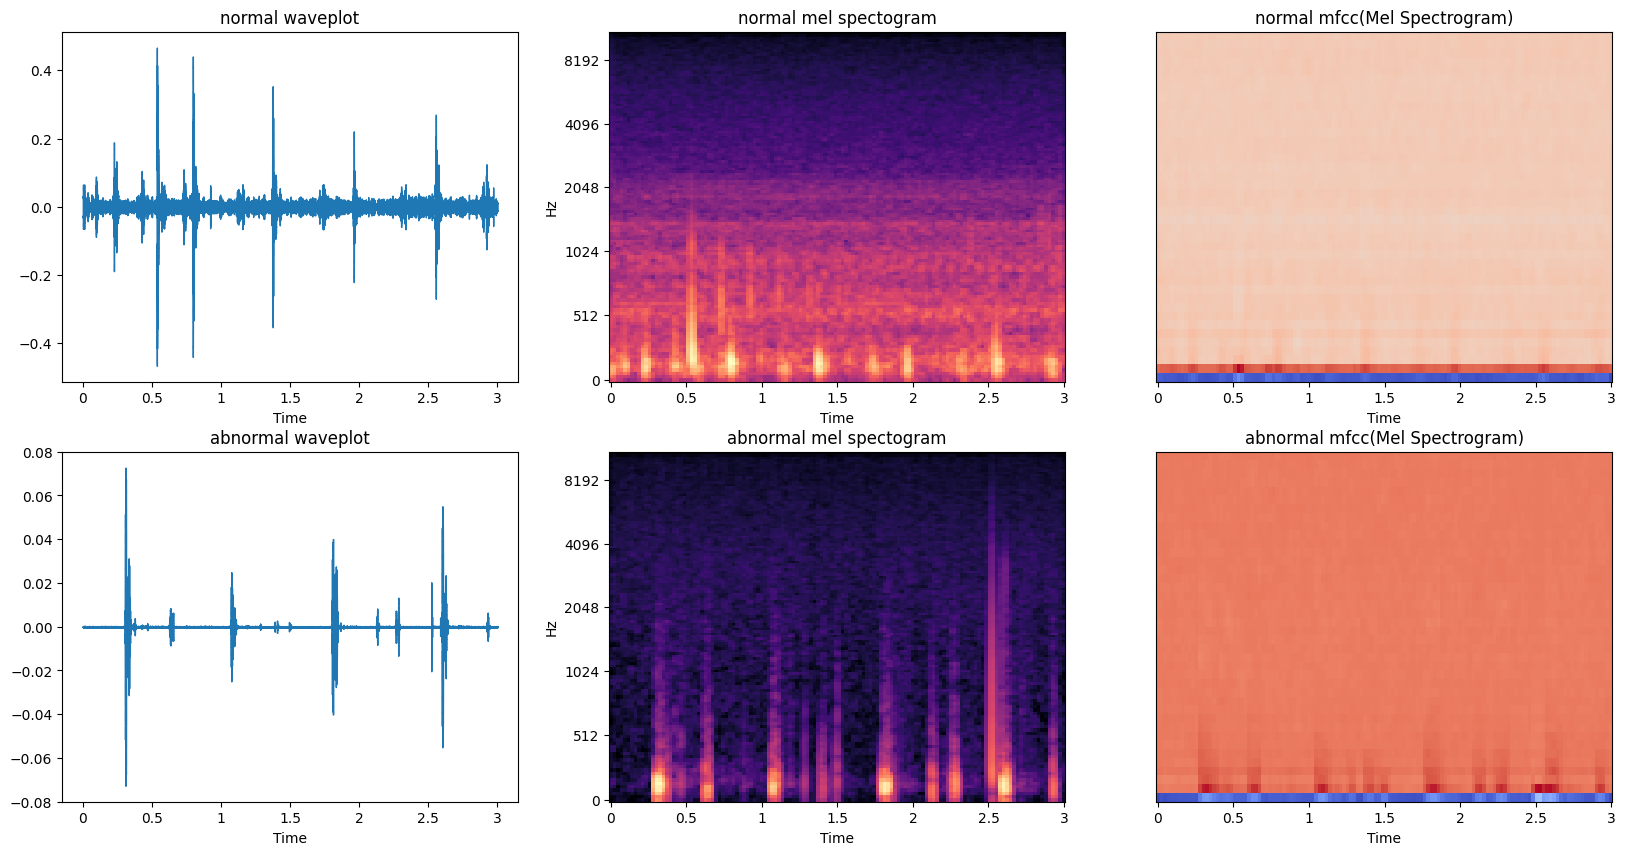

In [7]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveshow(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [10]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [11]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 49/49 [00:02<00:00, 21.76it/s]

X train: (195, 40, 130)
X test: (49, 40, 130)


In [15]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

label_mapping = dict(zip(train.label, y_train))
print(label_mapping)

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
print(class_wts)  
class_weights= {}
for index,value in enumerate(class_wts):
  class_weights[index]= value
print(class_weights)

{'abnormal': 0, 'normal': 1}
[0.82627119 1.26623377]
{0: 0.826271186440678, 1: 1.2662337662337662}


## Input Shapes

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (195, 40, 130, 1)
Y train: (195, 2)
X test: (49, 40, 130, 1)
Y test: (49, 2)


In [20]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 39, 129, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 19, 64, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 63, 32)        2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 31, 32)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 9, 31, 32)        

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [22]:
%%time
history = model.fit(x=x_train, y=y_train,
                    validation_data=(x_test, y_test), 
                    batch_size=16, 
                    epochs=300, 
                    class_weight=class_weights, 
                    shuffle=True)

Epoch 1/300
13/13 [==============================] - 3s 80ms/step - loss: 5.7820 - accuracy: 0.5385 - val_loss: 1.1292 - val_accuracy: 0.5714
Epoch 2/300
13/13 [==============================] - 1s 67ms/step - loss: 3.0361 - accuracy: 0.5333 - val_loss: 1.0097 - val_accuracy: 0.6327
Epoch 3/300
13/13 [==============================] - 1s 64ms/step - loss: 1.9480 - accuracy: 0.5692 - val_loss: 1.0259 - val_accuracy: 0.5510
Epoch 4/300
13/13 [==============================] - 1s 64ms/step - loss: 1.1010 - accuracy: 0.6564 - val_loss: 0.9121 - val_accuracy: 0.5714
Epoch 5/300
13/13 [==============================] - 1s 63ms/step - loss: 1.1510 - accuracy: 0.6051 - val_loss: 0.8420 - val_accuracy: 0.5918
Epoch 6/300
13/13 [==============================] - 1s 64ms/step - loss: 0.9340 - accuracy: 0.6615 - val_loss: 0.8766 - val_accuracy: 0.5510
Epoch 7/300
13/13 [==============================] - 1s 69ms/step - loss: 1.0938 - accuracy: 0.6205 - val_loss: 0.6493 - val_accuracy: 0.7755
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

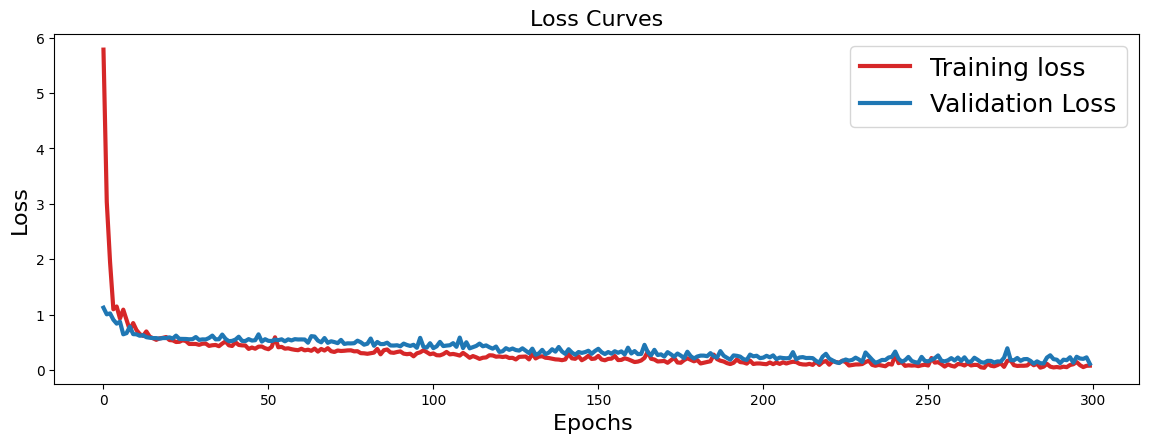

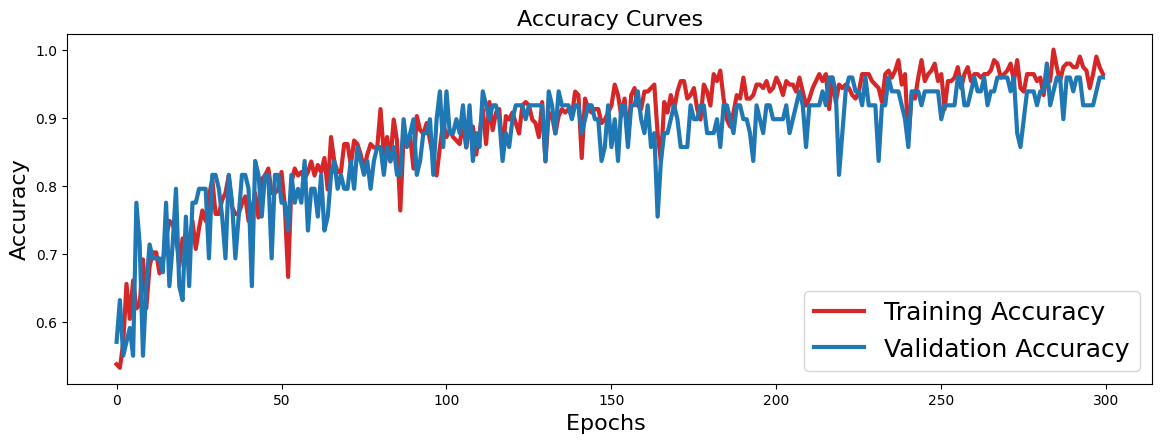

In [23]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [24]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2/2 [==============================] - 0s 23ms/step - loss: 0.1167 - accuracy: 0.9592
Test loss: 0.11665482074022293
Test accuracy: 0.9591836929321289


In [25]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

2/2 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

    abnormal       0.93      1.00      0.97        28
      normal       1.00      0.90      0.95        21

    accuracy                           0.96        49
   macro avg       0.97      0.95      0.96        49
weighted avg       0.96      0.96      0.96        49



In [26]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [27]:
# # load and evaluate a saved model
from keras.models import load_model
 
# # load model
model = load_model("heartbeat_classifier (normalised).h5")

# File to be classified
classify_file = "murmur__201108222233.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 0s 121ms/step
[[9.9999905e-01 9.6978317e-07]]


In [28]:
#@title
pred_class=model.predict(x_test) 
classes_x=np.argmax(pred_class,axis=1)
if classes_x[0]:
    print("Normal heartbeat")
    print("confidence:",pred[0][1])
else:
    print("Abnormal heartbeat")
    print("confidence:",pred[0][0])

1/1 [==============================] - 0s 31ms/step
Abnormal heartbeat
confidence: 0.99999905
